# Introduction

Predict Your Custom image with the help of this notebook


In [1]:
import gradio as gr
import numpy as np
from torchvision import transforms
import torch
from helper import *
import sys
import csv
from PIL import Image
from monoscene.models.monoscene import MonoScene

adding Base Dir Path /monoscene/MonoScene


# Loading Model

In [2]:
model_path = "/monoscene/MonoScene/trained_models/monoscene_nyu.ckpt"

csv.field_size_limit(sys.maxsize)
torch.set_grad_enabled(False)


project_scale = 1
feature = 200
full_scene_size = (60, 36, 60)
# data_module = NYUDataModule(
#     root=config.NYU_root,
#     preprocess_root=config.NYU_preprocess_root,
#     n_relations=config.n_relations,
#     frustum_size=config.frustum_size,
#     batch_size=int(config.batch_size / config.n_gpus),
#     num_workers=int(config.num_workers_per_gpu * config.n_gpus),
# )
# data_module.setup()
# data_loader = data_module.val_dataloader()


model = MonoScene.load_from_checkpoint(
        model_path,
        dataset="NYU",
        feature = feature,
        project_scale = project_scale,
        full_scene_size = full_scene_size,
    )


model.cuda()
model.eval()

# self.n_relations = n_relations
# self.frustum_size = frustum_size
# self.n_classes = 12
# self.root = os.path.join(root, "NYU" + split)
# self.preprocess_root = preprocess_root
# self.base_dir = os.path.join(preprocess_root, "base", "NYU" + split)
# self.fliplr = fliplr

# self.voxel_size = 0.08  # 0.08m
# self.scene_size = (4.8, 4.8, 2.88)  # (4.8m, 4.8m, 2.88m)
# self.img_W = 640
# self.img_H = 480
# self.cam_k = np.array([[518.8579, 0, 320], [0, 518.8579, 240], [0, 0, 1]])

# self.color_jitter = (
#     transforms.ColorJitter(*color_jitter) if color_jitter else None
# )

# self.scan_names = glob.glob(os.path.join(self.root, "*.bin"))

# self.normalize_rgb = transforms.Compose(
#     [
#         transforms.ToTensor(),
#         transforms.Normalize(
#             mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
#         ),
#     ]
# )



n_relations 4
Loading base model ()...

Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.


MonoScene(
  (projects): ModuleDict(
    (1): FLoSP()
    (2): FLoSP()
    (4): FLoSP()
    (8): FLoSP()
  )
  (net_3d_decoder): UNet3D(
    (process_1_4): Sequential(
      (0): Process(
        (main): Sequential(
          (0): Bottleneck3D(
            (conv1): Conv3d(200, 50, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
            (bn1): BatchNorm3d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv3d(50, 50, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1), bias=False)
            (bn2): BatchNorm3d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv3d(50, 50, kernel_size=(1, 3, 1), stride=(1, 1, 1), padding=(0, 1, 0), bias=False)
            (bn3): BatchNorm3d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv4): Conv3d(50, 50, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
            (bn4): BatchNorm3d(50, eps=1e-05

In [3]:
img_W, img_H = 640, 480

In [4]:
def get_projections(img_W, img_H):
    scale_3ds = [1, 2]
    data = {}
    for scale_3d in scale_3ds:
        scene_size = (4.8, 4.8, 2.88)
        vox_origin = np.array([-1.54591799,  0.8907361 , -0.05 ])
        voxel_size = 0.08

        calib = read_calib("/monoscene/MonoScene/calib.txt")
        cam_k = np.array([[518.8579, 0, 320], [0, 518.8579, 240], [0, 0, 1]])
        cam_pose = np.asarray([[ 9.6699458e-01,  4.2662762e-02,  2.5120059e-01,  0.0000000e+00],
       [-2.5147417e-01,  1.0867463e-03,  9.6786356e-01,  0.0000000e+00],
       [ 4.1018680e-02, -9.9908894e-01,  1.1779292e-02,  1.1794727e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]])
        T_velo_2_cam = np.linalg.inv(cam_pose)

        # compute the 3D-2D mapping
        projected_pix, fov_mask, pix_z = vox2pix(
            T_velo_2_cam,
            cam_k,
            vox_origin,
            voxel_size * scale_3d,
            img_W,
            img_H,
            scene_size,
        )

        data["projected_pix_{}".format(scale_3d)] = projected_pix
        data["pix_z_{}".format(scale_3d)] = pix_z
        data["fov_mask_{}".format(scale_3d)] = fov_mask
    return data

# Inference Custom Image

wrote to ./pred.pkl


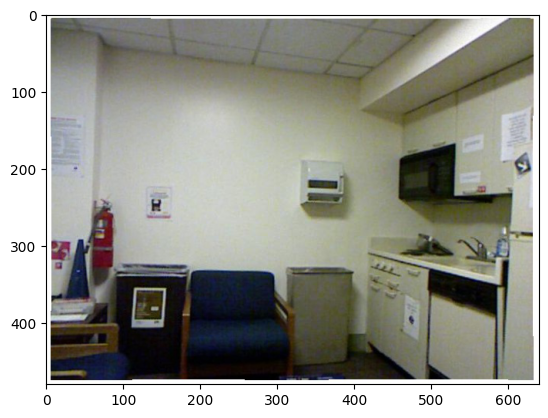

In [27]:
import os, pickle


img_W, img_H = 640, 480
def predict(img):
#     img_W, img_H = 640, 480
    img_W, img_H = 640, 480
    img = img.resize( (img_W, img_H), Image.Resampling.NEAREST)
    img = np.array(img, dtype=np.float32, copy=False) / 255.0
    
    normalize_rgb = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ])
    img = normalize_rgb(img)
   
    batch = get_projections(img_W, img_H)
    batch["img"] = img
    
    for k in batch:
        batch[k] = batch[k].unsqueeze(0).cuda()

    pred = model(batch)
    y_pred = torch.softmax(pred["ssc_logit"], dim=1).detach().cpu().numpy()
#     y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
#     fig = draw(y_pred.squeeze(), batch['fov_mask_1'].cpu())


    write_path = "./pred"
    filepath = os.path.join(write_path+ ".pkl")
    out_dict = {"y_pred": y_pred[0].astype(np.uint16)}
    out_dict["cam_pose"] = [[518.8579, 0, 320], [0, 518.8579, 240], [0, 0, 1]]
    out_dict["vox_origin"] = [-1.54591799,  0.8907361 , -0.05 ]
#     out_dict["pred"] = y_pred
    with open(filepath, "wb") as handle:
        pickle.dump(out_dict, handle)
        print("wrote to", filepath)
#     return fig
   
image_path = "/monoscene/MonoScene/nyu/NYU_dataset/depthbin/NYUtest/NYU0001_0000_color.jpg"
# image_path = "/monoscene/Monoscene/3-1.jpg"
# /home/sohaib/Documents/upwork_projects/robins/monoscene/Monoscene/1_1.jpg

color_image_path = image_path
image = Image.open(color_image_path)


import matplotlib.pyplot as plt
plt.imshow(image)
predict(image)

In [6]:
import os, pickle
filepath = os.path.join("/monoscene/MonoScene/nyu/NYU_dataset/depthbin/NYUtest/NYU0001_0000.pkl")

with open(filepath, "rb") as handle:
    data = pickle.load(handle)

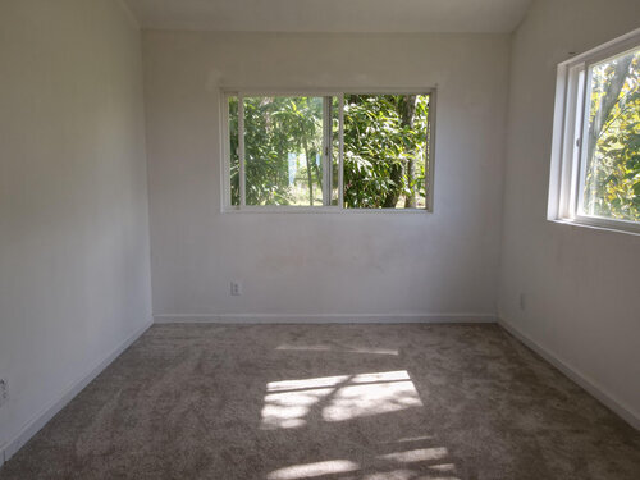

In [11]:
image.resize( (640, 480), Image.Resampling.NEAREST)
# img.resize((basewidth,hsize), Image.Resampling.LANCZOS)